This notebook attempts to compute the complexity score from this publication: https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0207879

However, the implementation is not perfect, certain parameters may change the complexity order of the images; plus the original paper's images can be "blocked" into even blocks of `2 x 2`. The image sizes for this dataset do not and some compromises are made. We can discuss if you want to know further.

Note: this has not been benchmarked against their images, so I (Tuan) do not know whether this is valid yet. Use at your own perils, or you can try to test against their images (may need to tweak the `scales` vector) to see if this implementation ends up with the same numbers as the paper.

This notebook also assumes there's an `images` folder containing natural scene images, for example, obtained by using the `image-download.ipynb`. Also note the starting index of image IDs in here and what is actually used in the Allen Brain dataset. Sometimes it will start at 1, i.e. the first image ID is 1 but sometimes it will start at 0, i.e. the first image ID is 0. Please note this and adjust accordingly.

In [1]:
# uncomment this out to install packages if they are missing
# %pip install numpy pandas scikit-image matplotlib tqdm seaborn

In [2]:
import glob
import re
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from skimage.io import imread, imread_collection
from skimage.transform import rescale, resize
from skimage.util.shape import view_as_blocks

from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
# make sure this outputs 118 (or whatever is the correct # for nat scene stim)
image_files = sorted(glob.glob('images/image_*.png'))
print(len(image_files))

118


In [4]:
# read all and norm to range 0-1
images = imread_collection(image_files)
images = [x / 255 for x in images]

In [5]:
def get_nearest_even_number(x):
    xf = int(np.floor(x))
    xc = int(np.ceil(x))
    even_xf = xf % 2 == 0  
    even_xc = xc % 2 == 0
    if xf == xc:
        if not even_xf:
            xf = xf - 1
        return xf
    
    assert even_xf + even_xc == 1
    if even_xf:
        return xf
    else:
        return xc

def get_block_variance(image, scale, block_shape):
    height, width = image.shape
    hs, ws = scale * height, scale * width
    hs, ws = get_nearest_even_number(hs), get_nearest_even_number(ws)
    hs = max(min(hs, height), 2)
    ws = max(min(ws, width), 2)
    
    resized_image = resize(image, (hs, ws), anti_aliasing=True)
    blocks = view_as_blocks(resized_image, block_shape=block_shape)
    Vb = blocks.var(axis=(-1,-2), ddof=1, keepdims=False).flatten()
    Vs = Vb.mean()
    
    S = np.mean([
        block_shape[0] * height / hs,
        block_shape[1] * width / ws,
    ])
    
    return dict(scale = S, variance = Vs)
    

def get_complexity_score(image, scales, block_shape):
    df = pd.DataFrame([
        get_block_variance(image, scale=s, block_shape=block_shape)
        for s in scales
    ])
    df = (
        df.sort_values(by='scale')
        .drop_duplicates(subset='scale')
        .reset_index(drop=True)
    )
    log_df = np.log(df)
    bound_s = log_df['scale'].max() - log_df['scale'].min()
    
    dv = np.diff(log_df['variance'].to_numpy())
    ds = np.diff(log_df['scale'].to_numpy())
    qs = 1 - np.power(dv / ds, 2) / 4.0
    trapz_qs = ds[1:] * (qs[1:] + qs[:-1]) / 2.0
    
    out = dict(
        Q_all = trapz_qs.sum() / bound_s,
        Q = trapz_qs[trapz_qs > 0].sum() / bound_s,
        aux = df
    )

    return out


In [6]:
scales = np.sort(np.unique(np.concatenate((
    np.linspace(0.05, 0.15, 10),
    np.logspace(-0.8, 0, 40)
))))

block_shape = (2,2)

In [7]:
complexities = []
for idx, image in tqdm(enumerate(images), total=len(images)):
    cpx = get_complexity_score(image, scales, block_shape)
    complexities.append(dict(
        image = image,
        image_id = idx+1,
        **cpx
    ))

  0%|          | 0/118 [00:00<?, ?it/s]

In [8]:
df_cpx = (
    pd.DataFrame(complexities)
    .sort_values('Q')
    .reset_index(drop=True)
)
df_cpx

image  image_id     Q_all  \
0    [[0.4823529411764706, 0.403921568627451, 0.576...        82 -1.082187   
1    [[0.9725490196078431, 1.0, 1.0, 1.0, 1.0, 1.0,...       114 -2.388584   
2    [[0.9647058823529412, 0.9647058823529412, 0.96...       115 -1.065014   
3    [[0.9098039215686274, 0.8862745098039215, 0.92...        44 -1.204733   
4    [[0.396078431372549, 0.396078431372549, 0.3960...        45 -0.004876   
..                                                 ...       ...       ...   
113  [[0.7254901960784313, 0.7176470588235294, 0.89...       101  0.801808   
114  [[0.5647058823529412, 0.5529411764705883, 0.50...       107  0.799454   
115  [[0.4549019607843137, 0.5411764705882353, 0.56...        76  0.818637   
116  [[0.38823529411764707, 0.4392156862745098, 0.4...        79  0.823991   
117  [[0.13725490196078433, 0.12549019607843137, 0....       117  0.809056   

            Q                                                aux  
0    0.188555          scale  variance
0    2.004274  0.00174...  
1    0.197475          scale  variance
0    2.004274  0.00090...  
2    0.243937          scale  variance
0    2.004274  0.00051...  
3    0.302169          scale  variance
0    2.004274  0.00175...  
4    0.355298          scale  variance
0    2.004274  0.00120...  
..        ...                                                ...  
113  0.804584          scale  variance
0    2.004274  0.00647...  
114  0.806111          scale  variance
0    2.004274  0.00371...  
115  0.818637          scale  variance
0    2.004274  0.00289...  
116  0.823991          scale  variance
0    2.004274  0.00435...  
117  0.825570          scale  variance
0    2.004274  0.00592...  

[118 rows x 5 columns]

In [9]:
# save the complexity scores into this csv file
# you can incorportate with your own excel/google sheets/or whatever
image_file_path = 'complexity-zanette18.csv'

# selecting only image_id and Q
# what is difference between Q and Q_all?
# Q: integration of only the positive part (see paper)
# Q_all: normal integration
(
    df_cpx
    .filter(['image_id', 'Q'])
    .sort_values('image_id')
    .reset_index(drop=True)
    .to_csv(image_file_path, index=False)
)
    

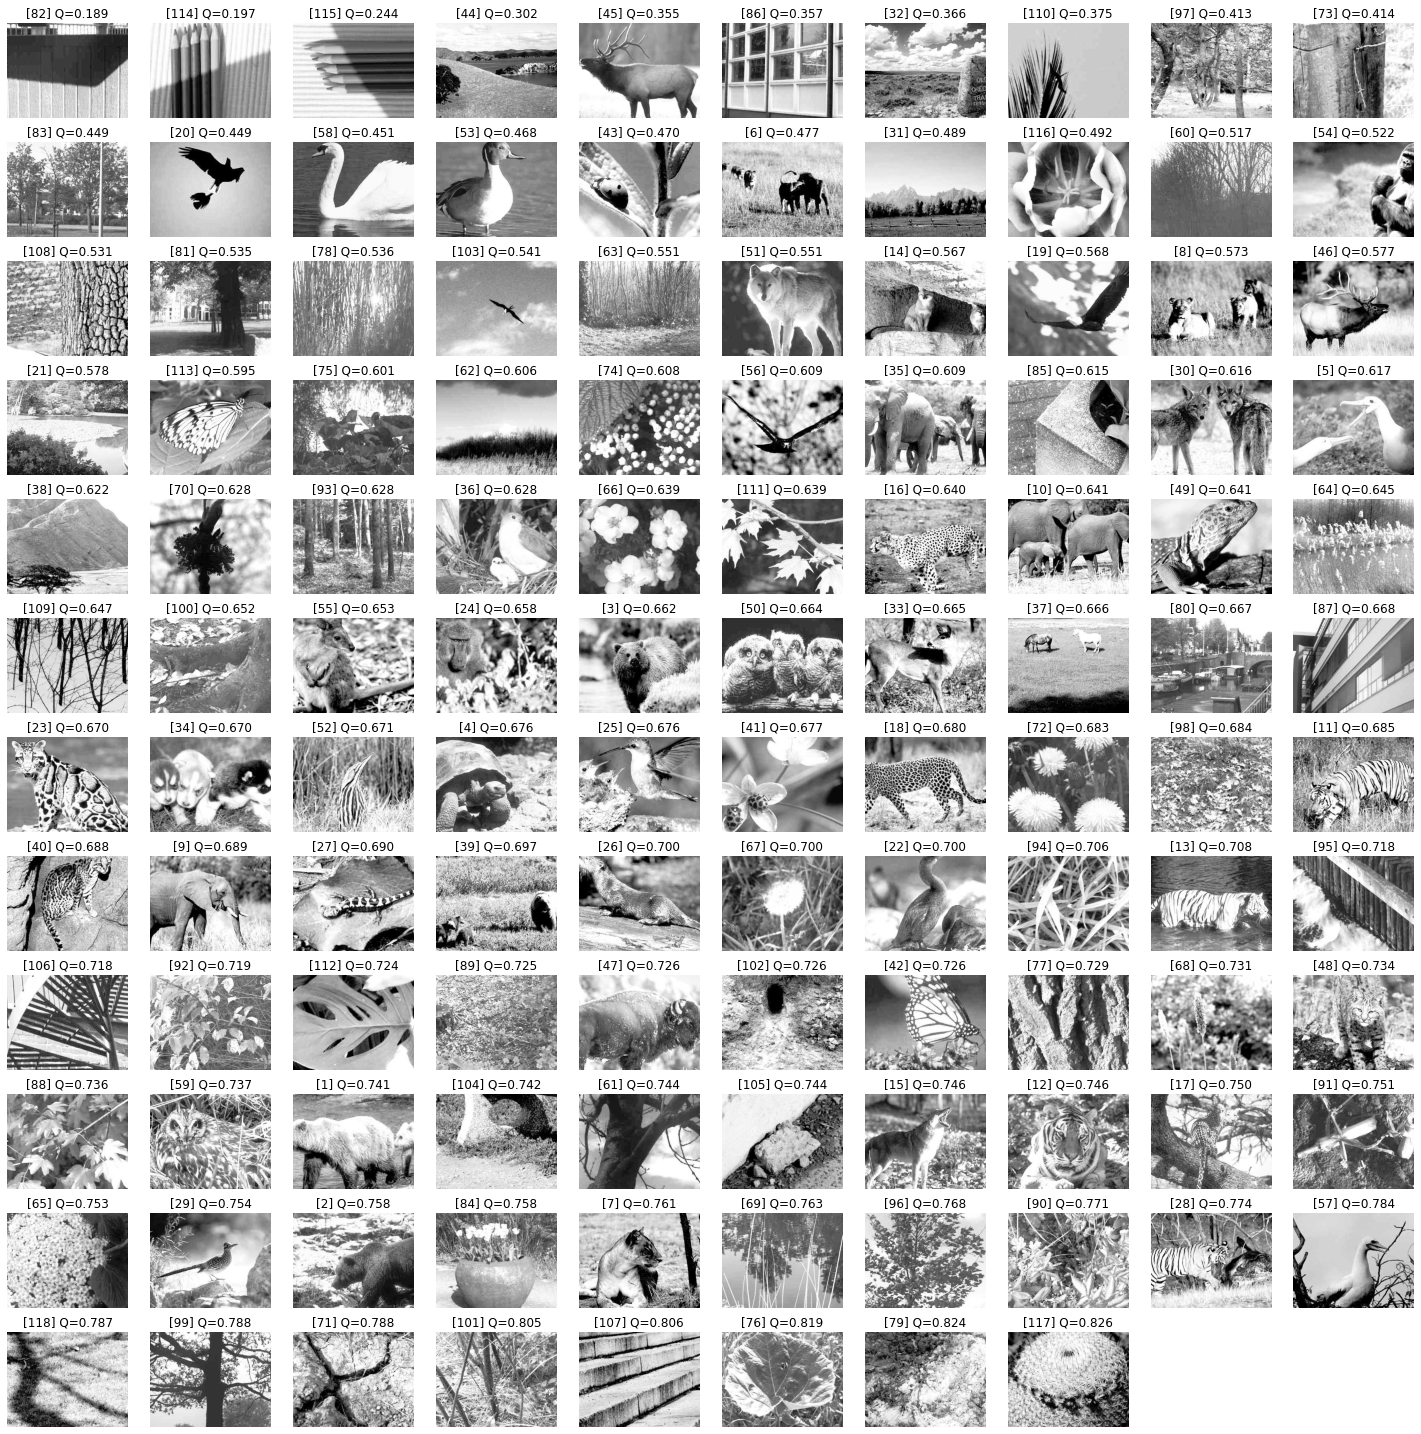

In [10]:
num_cols = 10
num_rows = int(np.ceil(len(df_cpx) / num_cols))

plt.figure(figsize=(20,20))
for i, row in df_cpx.iterrows():
    plt.subplot(num_rows, num_cols, i+1)
    plt.imshow(row['image'], cmap='Greys_r')
    plt.title(f"[{row['image_id']}] Q={row['Q']:.3f}")
    plt.axis('off')
    
plt.tight_layout()